In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from ucimlrepo import fetch_ucirepo
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from ucimlrepo import fetch_ucirepo

In [32]:
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)

# Data (as pandas dataframes)
X = cdc_diabetes_health_indicators.data.features
y = cdc_diabetes_health_indicators.data.targets

means = X.mean()
X = X.fillna(means)  # Apply the means to fill NaNs without using inplace=True

# Convert categorical variables using one-hot encoding if necessary
X = pd.get_dummies(X)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [33]:
X_train, X_test_val, y_train, y_test_val = train_test_split(X_scaled, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)

In [13]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Use Input layer to define the input shape
    Dense(512),
    Activation('relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256),
    Activation('relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128),
    Activation('relu'),
    BatchNormalization(),
    Dropout(0.1),
    Dense(64),
    Activation('relu'),
    BatchNormalization(),
    Dense(32),
    Activation('relu'),
    BatchNormalization(),
    Dense(1),
    Activation('sigmoid')
])

In [14]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=BinaryCrossentropy(),
              metrics=['accuracy'])

In [15]:
history = model.fit(X_train, y_train, epochs=40, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/40
2379/2379 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8239 - loss: 0.3961 - val_accuracy: 0.8630 - val_loss: 0.3187
Epoch 2/40
2379/2379 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8638 - loss: 0.3179 - val_accuracy: 0.8657 - val_loss: 0.3157
Epoch 3/40
2379/2379 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8635 - loss: 0.3185 - val_accuracy: 0.8653 - val_loss: 0.3143
Epoch 4/40
2379/2379 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8643 - loss: 0.3183 - val_accuracy: 0.8640 - val_loss: 0.3153
Epoch 5/40
2379/2379 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8653 - loss: 0.3150 - val_accuracy: 0.8633 - val_loss: 0.3151
Epoch 6/40
2379/2379 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8642 - loss: 0.3153 - val_accuracy: 0.8660 - val_loss: 0.3139
Epoch 7/40
2379/2379 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8650 - loss: 0.3150 - val_accuracy: 0.8649 - val_loss: 0.3147
Epoch 8/40
2379/2379 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8636 - loss: 0.3156 - 

In [17]:
model.save('tensorflow_diabetes_model.keras')

In [34]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(64)  # Use the same batch size as during training

# Initialize the loss object
loss_fn = BinaryCrossentropy()
test_losses = []

# Manually loop over the test dataset and compute the loss for each batch
for batch_x, batch_y in test_dataset:
    preds = model(batch_x)
    loss = loss_fn(batch_y, preds)
    test_losses.append(loss.numpy())

# Average test loss
avg_test_loss = np.mean(test_losses)
print(f"Average Test Loss: {avg_test_loss}")

# Compute the confusion matrix
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.54).astype(int)  # Apply your threshold
conf_matrix = confusion_matrix(y_test, y_pred.flatten())
test_accuracy = accuracy_score(y_test, y_pred.flatten())
print("Confusion Matrix:")
print(conf_matrix)
print(f"Test Accuracy: {test_accuracy:.4f}")

Average Test Loss: 0.31267645955085754
 374/1586 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step

2024-04-15 15:02:08.669872: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1586/1586 ━━━━━━━━━━━━━━━━━━━━ 1s 402us/step
Confusion Matrix:
[[43269   520]
 [ 6172   775]]
Test Accuracy: 0.8681


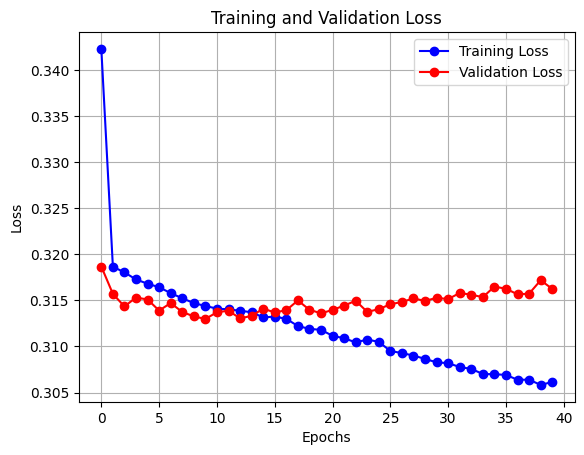

In [35]:
plt.figure()
plt.plot(history.history['loss'], 'bo-', label='Training Loss')
plt.plot(history.history['val_loss'], 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('tensorflow_diabetes_train_val_loss.svg', format='svg')
plt.show()

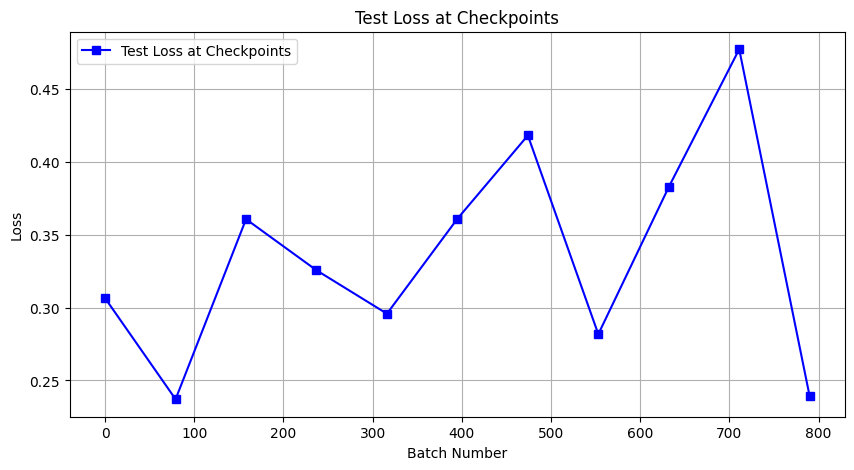

In [37]:
# Define checkpoints for plotting
checkpoints = range(0, len(test_losses), max(1, len(test_losses) // 10))  # Display every 10th batch loss
selected_test_losses = [test_losses[i] for i in checkpoints]

# Plotting the selected checkpoints
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(checkpoints, selected_test_losses, 'bs-', label='Test Loss at Checkpoints')
plt.title('Test Loss at Checkpoints')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Save the figure in SVG format
plt.savefig('tensorflow_test_loss_checkpoints.svg', format='svg')
plt.show()
